<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [2]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [3]:
file = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Secretaria Energia\\SARIMA\\TD_S_SescoWebUP_07_2022.csv'
datos = pd.read_csv(file, usecols=['Date','TotalPet'])
datos


,Date,TotalPet
0,1/1/2009,97924.5991
1,2/1/2009,100044.0659
2,3/1/2009,99329.5204
3,4/1/2009,98880.3859
4,5/1/2009,98151.9991
...,...,...
158,3/1/2022,89459.4248
159,4/1/2022,90490.6676
160,5/1/2022,91589.1089
161,6/1/2022,91155.8765


In [4]:
datos["Date"] = pd.to_datetime(datos["Date"])

datos = datos.set_index('Date')


In [5]:
datos['1000TotalPet'] = datos['TotalPet']/1000

In [6]:
datos.describe()

,TotalPet,1000TotalPet
count,163.000000,163.000000
mean,84443.916705,84.443917
std,6495.752824,6.495753
min,71163.538400,71.163538
25%,79468.451400,79.468451
50%,84406.510100,84.406510
75%,88486.056450,88.486056
max,100044.065900,100.044066


In [7]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [8]:
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq=None)

In [9]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

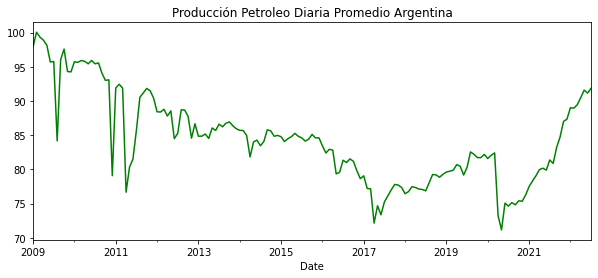

In [10]:
datos['1000TotalPet'].plot(figsize=(10,4), title='Producción Petroleo Diaria Promedio Argentina', color='green')
plt.show()

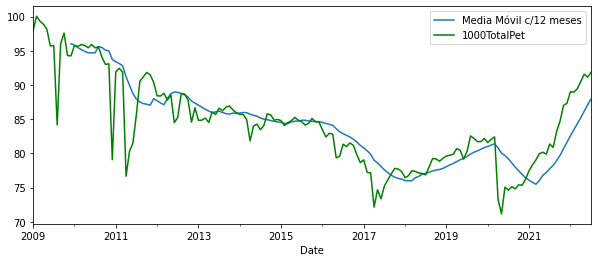

In [11]:
datos['1000TotalPet'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['1000TotalPet'].plot(color='green')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

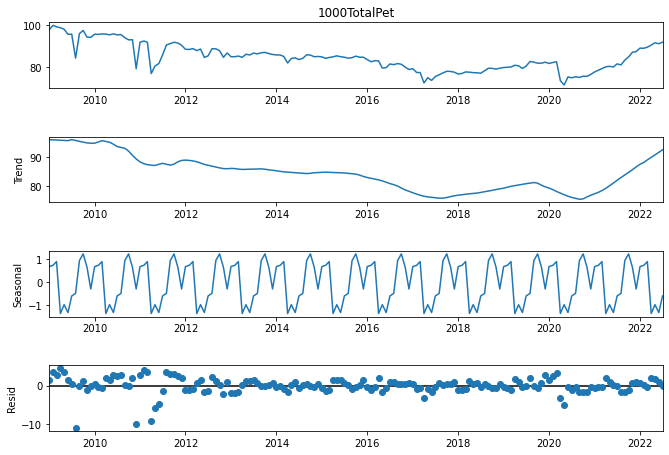

In [12]:
decomp = seasonal_decompose(datos['1000TotalPet'], period=12, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [13]:
pValue = adfuller(datos['1000TotalPet'])[1]
pValue

0.16929624800270449

In [14]:
p_value_adfuller(datos['1000TotalPet'])

P-value:  0.16929624800270449
No se rechaza la hipóteis nula, los datos no son estacionarios


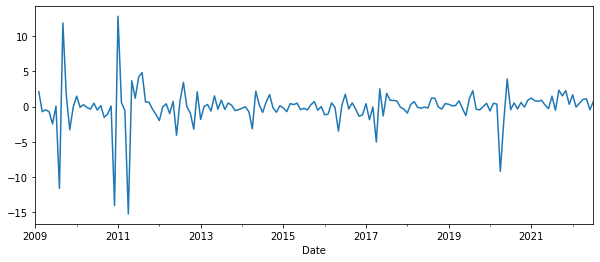

In [15]:
datos['1a diff']= datos['1000TotalPet'] - datos['1000TotalPet'].shift(1) 
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [16]:
p_value_adfuller((datos['1a diff']).dropna())

P-value:  1.2919028643504927e-18
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


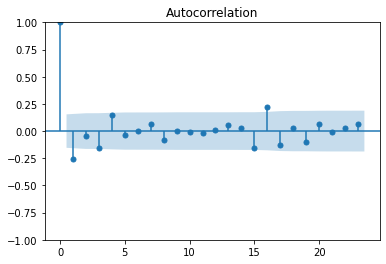

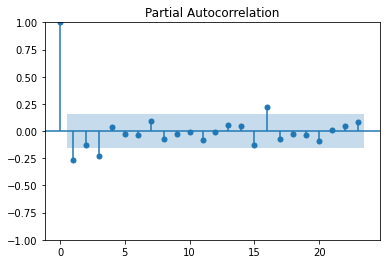

In [17]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [18]:
train = datos.loc[:'2022-1-1','1000TotalPet']
test = datos.loc['2022-1-1':,'1000TotalPet']

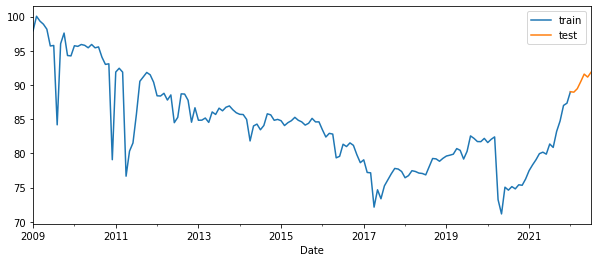

In [19]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [20]:
100*len(test)/len(train)

4.45859872611465

In [21]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [22]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [23]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2022-1-1','1000TotalPet'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit()#method_kwargs={"warn_convergence": False}
      aic_modelos[parametros, parametros_s] = results.aic
      # print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [24]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((2, 1, 2), (2, 1, 2, 12))
AIC:  463.4695830140479


In [36]:
modelo = SARIMAX(datos['1000TotalPet'],
                       order = (2,1,2),
                       seasonal_order = (2,1,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1660      0.541     -0.307      0.759      -1.226       0.894
ar.L2         -0.1758      0.677     -0.260      0.795      -1.502       1.150
ma.L1          0.1060      0.546      0.194      0.846      -0.965       1.177
ma.L2          0.0309      0.669      0.046      0.963      -1.280       1.342
ar.S.L12      -0.0157      0.277     -0.057      0.955      -0.558       0.526
ar.S.L24      -0.0034      0.003     -1.123      0.262      -0.009       0.003
ma.S.L12      -0.5930      0.340     -1.743      0.081      -1.260       0.074
ma.S.L24      -0.1749      0.197     -0.888      0.374      -0.561       0.211
sigma2         3.0593      0.349      8.758      0.000       2.375       3.744


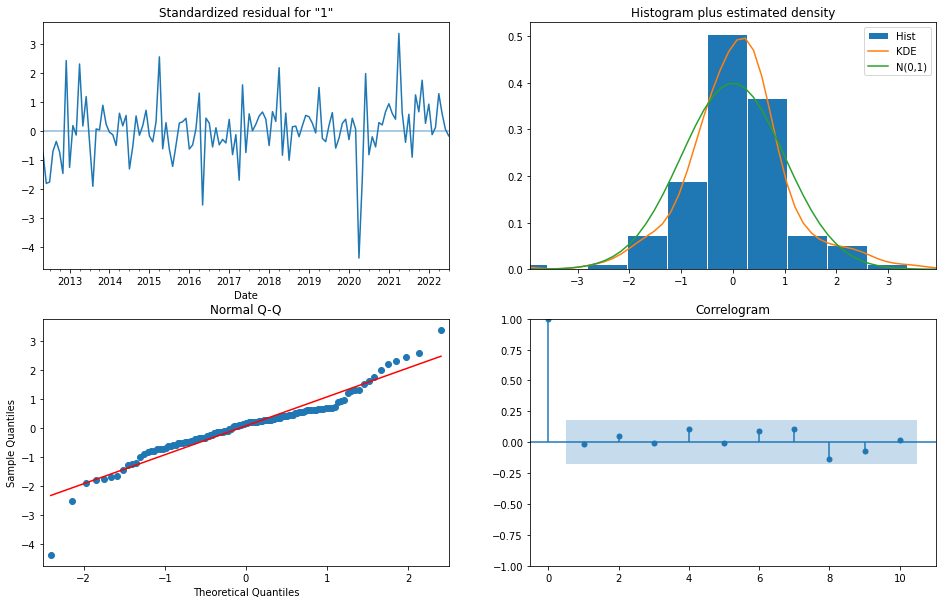

In [37]:
resultados.plot_diagnostics(figsize = (16,10))
plt.show()

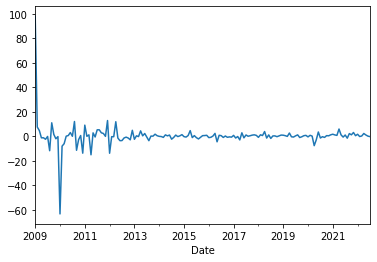

In [38]:
resultados.resid.plot()
plt.show()

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


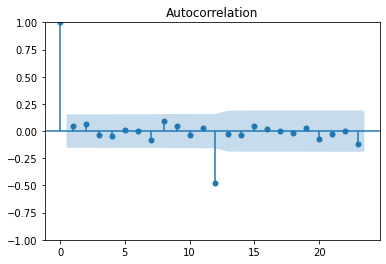

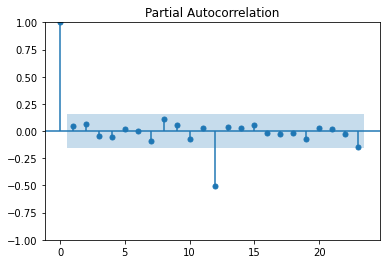

In [39]:
plot_acf(resultados.resid)
plot_pacf(resultados.resid)
plt.show()

# Validación

In [40]:
pred = resultados.get_prediction(start=pd.to_datetime('2022-01-01'),
                                 end=pd.to_datetime('2025-01-01'))
pred.predicted_mean

2022-01-01     87.368946
2022-02-01     89.156571
2022-03-01     89.228009
2022-04-01     88.217780
2022-05-01     90.525827
2022-06-01     91.038670
2022-07-01     92.143103
2022-08-01     92.451016
2022-09-01     93.648896
2022-10-01     94.272844
2022-11-01     94.841932
2022-12-01     94.900013
2023-01-01     95.524598
2023-02-01     95.481547
2023-03-01     95.860074
2023-04-01     94.471821
2023-05-01     94.882938
2023-06-01     94.881901
2023-07-01     95.609312
2023-08-01     96.378069
2023-09-01     97.194626
2023-10-01     97.622087
2023-11-01     97.741364
2023-12-01     97.772801
2024-01-01     98.188082
2024-02-01     98.193318
2024-03-01     98.561069
2024-04-01     96.804911
2024-05-01     97.064709
2024-06-01     97.102687
2024-07-01     97.893418
2024-08-01     98.641948
2024-09-01     99.461473
2024-10-01     99.898674
2024-11-01    100.031542
2024-12-01    100.063622
2025-01-01    100.485806
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower 1000TotalPet,upper 1000TotalPet
2022-01-01,83.934372,90.803519
2022-02-01,85.723504,92.589639
2022-03-01,85.794955,92.661064
2022-04-01,84.785322,91.650238
2022-05-01,87.093375,93.958280
2022-06-01,87.606219,94.471121
2022-07-01,88.710652,95.575554
2022-08-01,89.018565,95.883467
2022-09-01,88.938143,98.359650
2022-10-01,88.811365,99.734323


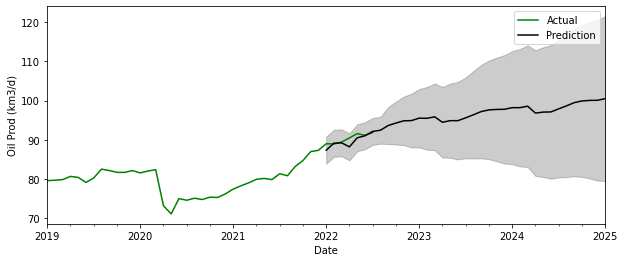

In [50]:
fig = datos.loc['2019-01-01':,'1000TotalPet'].plot(label = 'Actual', 
                                           figsize =(10,4), color='green')
pred.predicted_mean.plot(ax = fig, label = 'Prediction', color='black')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.ylabel('Oil Prod (km3/d)')
plt.legend()
plt.show()

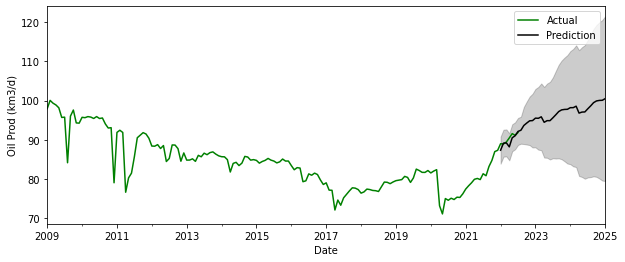

In [49]:
fig = datos.loc['2009-01-01':,'1000TotalPet'].plot(label = 'Actual', 
                                           figsize =(10,4), color='green')
pred.predicted_mean.plot(ax = fig, label = 'Prediction', color='black')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.ylabel('Oil Prod (km3/d)')
plt.legend()
plt.show()

In [44]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2022-01-01':'2025-01-01','1000TotalPet']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 1.31
La raiz del error cuadrático medio es 1.15


In [45]:
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(datos['1000TotalPet'].mean()), 3)} %")

Porcentaje de error con respecto al promedio: 1.356 %
